In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy import fft
from scipy.optimize import curve_fit

In [4]:
#variable values
tau_p = 1e-12 
tau_c = 1e-09 
N_0 = 1.5e+08
g = 1.5e+04
alpha = 3
beta = 1e+04
e = 1.6e-19
I_th = ((N_0*e)/tau_c) + (e/(g*tau_p*tau_c))
I_off = 0.9*I_th
h_nu = 6.63e-34 * 3e10 / 650e-09
print(h_nu)
print(I_th)
print(I_off)

3.06e-17
0.034666666666666665
0.0312


In [14]:
#Function to find the steady state solutions
def fn_solution(I, I_th,s): 
    if(I>I_th):
        S = (tau_p/e)*(I - I_th)/(1+(s/(g*tau_c)))
        N = ((I/e) - (S/tau_p))*tau_c
        G = (N-N_0)/(1+s*S)
    else:
        S = 0 
        N = I*tau_c/e
        G = (N-N_0)/(1+s*S)
    
    return(G,N,S)  

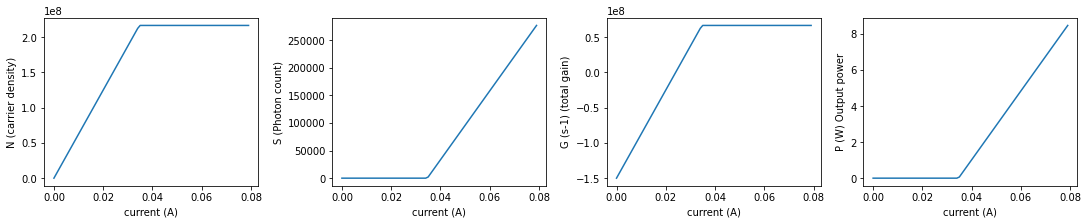

In [15]:
#Let's first find the Steady state solution with no noise and no gain suppression
I_arr = np.arange(0,0.08, 0.001)
G_arr = np.arange(0,0.08, 0.001)
N_arr = np.arange(0,0.08, 0.001)
S_arr = np.arange(0,0.08, 0.001)
P_arr = np.arange(0,0.08, 0.001)
for i in range(len(I_arr)):
    G_arr[i], N_arr[i], S_arr[i] = fn_solution(I_arr[i], I_th, 0)
P_arr = (h_nu/tau_p)*S_arr

fig, ax = plt.subplots(ncols = 4,constrained_layout=True)
fig.set_size_inches(15, 3)
ax[0].plot(I_arr,N_arr)
ax[1].plot(I_arr,S_arr)
ax[2].plot(I_arr,G_arr)
ax[3].plot(I_arr,P_arr)
ax[0].set_xlabel('current (A)')
ax[1].set_xlabel('current (A)')
ax[2].set_xlabel('current (A)')
ax[3].set_xlabel('current (A)')
ax[0].set_ylabel('N (carrier density)');
ax[1].set_ylabel('S (Photon count)');
ax[2].set_ylabel('G (s-1) (total gain)');
ax[3].set_ylabel('P (W) Output power');

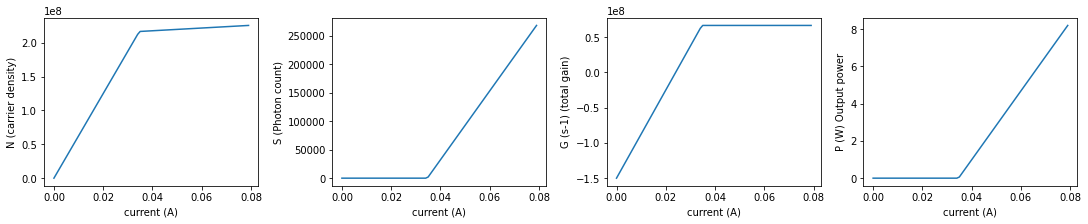

In [16]:
#Let's first find the Steady state solution with gain suppression
I_arr = np.arange(0,0.08, 0.001)
G_arr = np.arange(0,0.08, 0.001)
N_arr = np.arange(0,0.08, 0.001)
S_arr = np.arange(0,0.08, 0.001)
P_arr = np.arange(0,0.08, 0.001)
for i in range(len(I_arr)):
    G_arr[i], N_arr[i], S_arr[i] = fn_solution(I_arr[i], I_th, 5e-07)
P_arr = (h_nu/tau_p)*S_arr

fig, ax = plt.subplots(ncols = 4,constrained_layout=True)
fig.set_size_inches(15, 3)
ax[0].plot(I_arr,N_arr)
ax[1].plot(I_arr,S_arr)
ax[2].plot(I_arr,G_arr)
ax[3].plot(I_arr,P_arr)
ax[0].set_xlabel('current (A)')
ax[1].set_xlabel('current (A)')
ax[2].set_xlabel('current (A)')
ax[3].set_xlabel('current (A)')
ax[0].set_ylabel('N (carrier density)');
ax[1].set_ylabel('S (Photon count)');
ax[2].set_ylabel('G (s-1) (total gain)');
ax[3].set_ylabel('P (W) Output power');

In [10]:
def evolve_system(num_steps, h, s, is_noise, I_on, on_step): #duration and step in ps
    I = np.zeros(num_steps)
    E = np.zeros(num_steps, dtype = complex)
    N = np.zeros(num_steps)
    G = np.zeros(num_steps)
    
    #initialzing values at t=0 for stability conditions at I < I_th
    E[0] = 1e-20 #very close to 0
    N[0] = I_off*tau_c/e
    G[0] = g*(N[0] - N_0)/(1+s*((np.absolute(E[0]))**2))
    I[0] = I_off

    #running for time duration Euler cromer method
    for i in range(1, num_steps):
        xi = np.random.normal(0, 1) if (is_noise ==1 ) else 0
        E[i] = E[i-1] +  h*(0.5*(1+alpha*1j)*(G[i-1] -  (1/tau_p))*E[i-1]) +  (xi*np.sqrt(4*h*beta*N[i-1]))
        N[i] = N[i-1] +  h*((I[i-1]/e) -  (N[i-1]/tau_c) -  G[i-1]*((np.absolute(E[i-1]))**2))
        G[i] = g*(N[i-1] - N_0)/(1+s*((np.absolute(E[i-1]))**2))
        I[i] = (I_on) if (i >= on_step) else I_off
    return(E, G, N, I)

In [ ]:
#Let's simulate without noise and gain suppression
num_steps   = 50000
h           = 1e-13 #ps
on_step     = 10000
is_noise    = 0
I_on        = 2*I_th
s           = 0
E, G, N, I  = evolve_system(num_steps, h, s, is_noise, I_on, on_step)


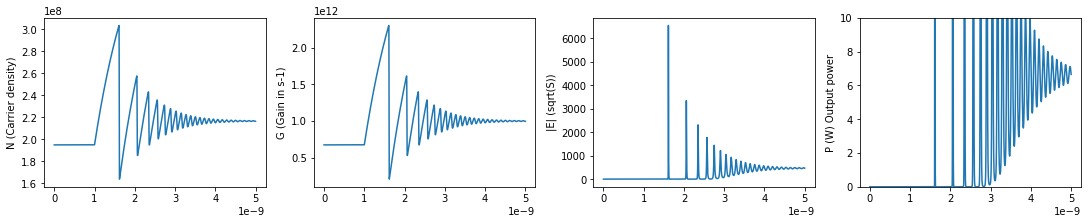

In [ ]:
T = np.linspace(0, num_steps*h, num_steps)
fig, ax = plt.subplots(ncols = 4,constrained_layout=True)
fig.set_size_inches(15, 3)
P = (h_nu/tau_p)*np.abs(E)*np.abs(E)
ax[0].plot(T,N)
ax[1].plot(T,G)
ax[2].plot(T,np.abs(E))
ax[3].plot(T,P)
ax[3].set_ylim(0,10)
ax[0].set_ylabel('N (Carrier density)');
ax[1].set_ylabel('G (Gain in s-1)');
ax[2].set_ylabel('|E| (sqrt(S))');
ax[3].set_ylabel('P (W) Output power');

In [ ]:
#Let's simulate without noise and with gain suppression
num_steps   = 50000
h           = 1e-13 #ps
on_step     = 10000
is_noise    = 0
I_on        = 2*I_th
s           = 5e-07
E, G, N, I  = evolve_system(num_steps, h, s, is_noise, I_on, on_step)

T_switch_on =  6.089e-10
T_delay =  1.281e-10


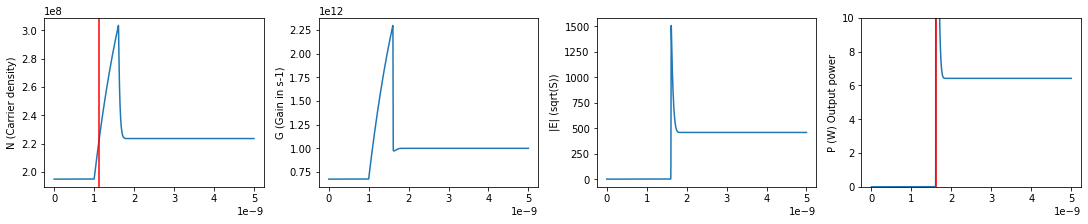

In [ ]:
#Let's find the Switch on time and delay time
T_sw_on = h*(np.amin(np.where(P > P[-1])) - on_step)
print("T_switch_on = ", T_sw_on)
T_delay = h*(np.amin(np.where(N > N[-1])) - on_step)
print("T_delay = ", T_delay)

T = np.linspace(0, num_steps*h, num_steps)
fig, ax = plt.subplots(ncols = 4,constrained_layout=True)
fig.set_size_inches(15, 3)
P = (h_nu/tau_p)*np.abs(E)*np.abs(E)
ax[0].plot(T,N)
ax[1].plot(T,G)
ax[2].plot(T,np.abs(E))
ax[3].plot(T,P)
ax[3].set_ylim(0,10)
ax[0].set_ylabel('N (Carrier density)');
ax[1].set_ylabel('G (Gain in s-1)');
ax[2].set_ylabel('|E| (sqrt(S))');
ax[3].set_ylabel('P (W) Output power');
ax[3].axvline(x = h*np.amin(np.where(P > P[-1])), color = 'r')
ax[0].axvline(x = h*np.amin(np.where(N > N[-1])), color = 'r')

FWHM  of PSD =  [1.34066584]


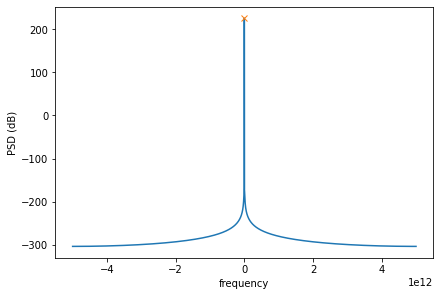

In [ ]:
#Let's find the spectrum and Linewidth of this simulation
h_stable = int(on_step + (1e-09/h)) #on time + 1ns
E_stable = E[h_stable:-1]
f = np.fft.fftshift(np.fft.fftfreq(len(E_stable), h))
N = len(f)
PSD = np.array(np.abs(np.fft.fftshift(np.fft.fft((E_stable)))) ** 2)/N
PSD_db = 10*np.log(PSD)
peaks, _ = signal.find_peaks(PSD_db , height = 0, threshold = 3)
FWHM = signal.peak_widths(PSD_db, peaks, rel_height=0.5)

fig, ax = plt.subplots(ncols = 1,constrained_layout=True)
ax.plot(f, PSD_db, peaks, PSD_db[peaks], "x")
ax.set_ylabel('PSD (dB)')
ax.set_xlabel('frequency')
print("FWHM  of PSD = ", FWHM[0])


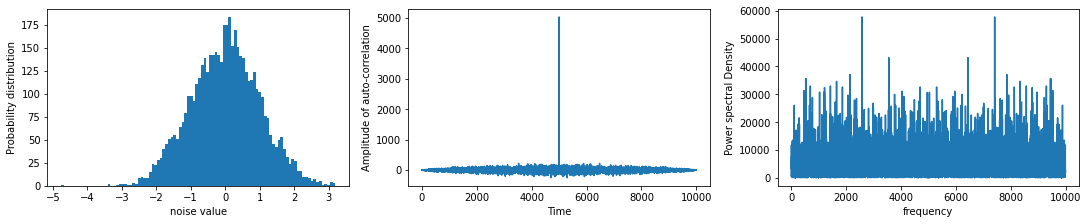

In [17]:
#Before moving on to analysing laser evolution with noise,
#Let's establish numpy generated noise as gaussian white noise
time_scale = np.arange(0,5000,1)
#noise = np.random.normal(loc=0.0, scale=1, size=len(time_scale))
noise = []
for i in range(len(time_scale)):
    noise.append(np.random.normal(loc=0.0, scale=1))

auto_corr = signal.correlate(noise, noise)
corr_time = np.arange(0,len(auto_corr),1)

P_f = np.absolute(fft.fft(auto_corr))
f = np.arange(0,len(P_f),1)

fig, ax = plt.subplots(ncols = 3,constrained_layout=True)
fig.set_size_inches(15, 3)
ax[0].hist(noise, bins=100)
ax[1].plot(corr_time, auto_corr)
ax[2].plot(f,P_f)
ax[0].set_xlabel('noise value')
ax[1].set_xlabel('Time')
ax[2].set_xlabel('frequency')
ax[0].set_ylabel('Probability distribution');
ax[1].set_ylabel('Amplitude of auto-correlation');
ax[2].set_ylabel('Power spectral Density');


In [ ]:
#Let's simulate with noise and with gain suppression
num_steps   = 50000
h           = 1e-13 #ps
on_step     = 0
is_noise    = 1
I_on        = 2*I_th
s           = 5e-07
E, G, N, I  = evolve_system(num_steps, h, s, is_noise, I_on, on_step)

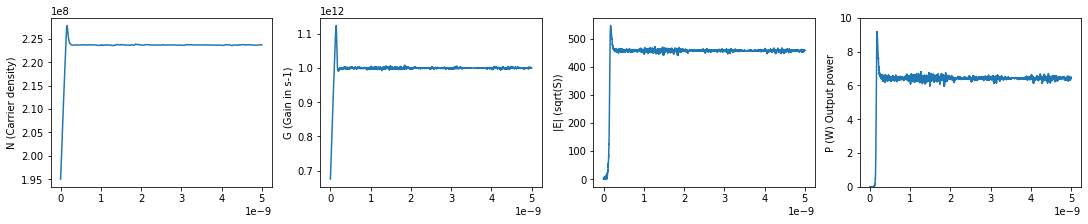

In [ ]:
T = np.linspace(0, num_steps*h, num_steps)
fig, ax = plt.subplots(ncols = 4,constrained_layout=True)
fig.set_size_inches(15, 3)
P = (h_nu/tau_p)*np.abs(E)*np.abs(E)
ax[0].plot(T,N)
ax[1].plot(T,G)
ax[2].plot(T,np.abs(E))
ax[3].plot(T,P)
ax[3].set_ylim(0,10)
ax[0].set_ylabel('N (Carrier density)');
ax[1].set_ylabel('G (Gain in s-1)');
ax[2].set_ylabel('|E| (sqrt(S))');
ax[3].set_ylabel('P (W) Output power');

In [ ]:
#Let's find the spectrum and Linewidth of this simulation
h_stable = int(on_step + (1e-09/h)) #on time + 1ns
E_dummy = np.zeros(5000000) #zero padding
E_stable = np.concatenate((E[h_stable:-1],E_dummy), axis=None)
f = np.fft.fftshift(np.fft.fftfreq(len(E_stable), h))
N = len(f)
PSD = np.array(np.abs(np.fft.fftshift(np.fft.fft((E_stable)/N))) ** 2)

In [ ]:
def lorentzian_fit(x, A, x0, FWHM):
      return ((A/np.pi)*FWHM*(1/((x-x0)**2 + FWHM**2)))

#Theoretical expectations
var_guess = [np.max(PSD), 0, 1e7]
popt, pcov = curve_fit(lorentzian_fit, f[int(N/2 - 200000):int(N/2 + 200000)], PSD[int(N/2 - 200000):int(N/2 + 200000)], p0=var_guess, bounds=(0, 1e8), method='trf')
popt, pcov = curve_fit(lorentzian_fit, f[int(N/2 - 200000):int(N/2 + 200000)], PSD[int(N/2 - 200000):int(N/2 + 200000)], p0=popt, bounds=(0, 1e8), method='trf')
fwhm = popt[2]
print(fwhm)

9171821.20799035


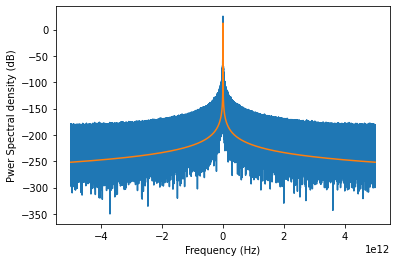

In [ ]:
PSD_db = 10*np.log(PSD)
lorentzian_db = 10*np.log(lorentzian_fit(f, *popt))
plt.plot(f, PSD_db)
plt.plot(f, lorentzian_db)
plt.ylabel("Pwer Spectral density (dB)")
plt.xlabel("Frequency (Hz)")
plt.show()

Text(0, 0.5, 'Probability districution')

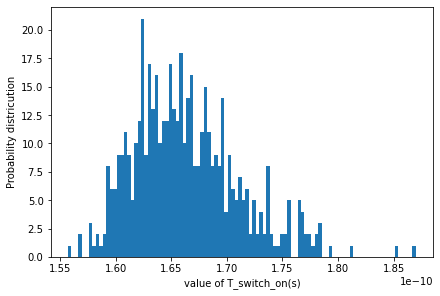

In [ ]:
#Let's find the distribution of T_switch on when we have noise
T_sw_on = np.zeros(500)
for rep in range(len(T_sw_on)):
  num_steps   = 10000
  h           = 1e-13 #ps
  on_step     = 0
  is_noise    = 1
  I_on        = 2*I_th
  s           = 5e-07
  E, G, N, I  = evolve_system(num_steps, h, s, is_noise, I_on, on_step)
  P           = (h_nu/tau_p)*np.abs(E)*np.abs(E)
  T_sw_on[rep]= h*(np.amin(np.where(P > P[-1])) - on_step)

fig, ax = plt.subplots(ncols = 1,constrained_layout=True)
ax.hist(T_sw_on, bins=100)
ax.set_xlabel('value of T_switch_on(s)')
ax.set_ylabel('Probability districution')

In [ ]:
#Let's plot the FWHM for different pump currents

Pump_curr = I_th*np.arange(1.2, 2.1, 0.1)
FWHM_values = np.zeros(len(Pump_curr))
num_steps   = 50000
h           = 1e-13 #ps
on_step     = 0

for i,I_on in enumerate(Pump_curr):
  #averaging fft  thrice
  h_stable = int(on_step + (1e-09/h)) #on time + 1ns
  E_dummy = np.zeros(5000000) #zero padding for fft noise filtering
  PSD = np.zeros(num_steps - h_stable + len(E_dummy)-1)
  for j in range(1):
    E, G, N, I  = evolve_system(num_steps, h, 5e-07, 1, I_on, on_step)
    E_stable = np.concatenate((E[h_stable:-1],E_dummy), axis=None)
    f = np.fft.fftshift(np.fft.fftfreq(len(E_stable), h))
    N = len(f)
    PSD = PSD + np.array(np.abs(np.fft.fftshift(np.fft.fft((E_stable)/N))) ** 2)
  PSD = PSD/1
  var_guess = [np.max(PSD), 0, 1e7]
  popt, pcov = curve_fit(lorentzian_fit, f[int(N/2 - 200000):int(N/2 + 200000)], PSD[int(N/2 - 200000):int(N/2 + 200000)], p0=var_guess, bounds=(0, 1e8), method='trf')
  popt, pcov = curve_fit(lorentzian_fit, f[int(N/2 - 200000):int(N/2 + 200000)], PSD[int(N/2 - 200000):int(N/2 + 200000)], p0=popt, bounds=(0, 1e8), method='trf')
  print(popt[2])
  FWHM_values[i] = popt[2]


22310184.95674904
18396141.61132333
14734338.533749828
14189670.720198818
11974763.768326825
10879711.283816738
10161446.54956979
9576997.398215214
8997716.54268629


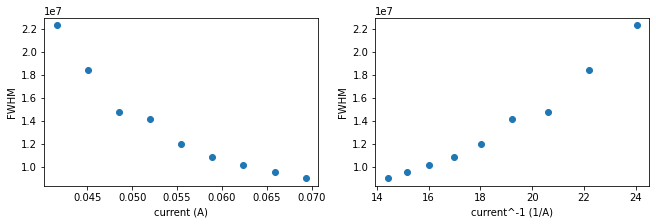

In [ ]:
#Let's plot FWHM variation
Pump_inverse = np.divide(np.ones(len(Pump_curr)), Pump_curr)
fig, ax = plt.subplots(ncols = 2,constrained_layout=True)
fig.set_size_inches(9, 3)
ax[0].scatter(Pump_curr, FWHM_values)
ax[1].scatter(Pump_inverse, FWHM_values)
ax[0].set_ylabel('FWHM');
ax[1].set_ylabel('FWHM');
ax[0].set_xlabel('current (A)');
ax[1].set_xlabel('current^-1 (1/A)');

In [5]:
def evolve_small_signal(num_steps, h, s, is_noise, I_on, on_step, w): #duration and step in ps
    I = np.zeros(num_steps)
    E = np.zeros(num_steps, dtype = complex)
    N = np.zeros(num_steps)
    G = np.zeros(num_steps)
    
    #initialzing values at t=0 for stability conditions at I < I_th
    E[0] = 1e-20 #very close to 0
    N[0] = I_off*tau_c/e
    G[0] = g*(N[0] - N_0)/(1+s*((np.absolute(E[0]))**2))
    I[0] = I_off

    #running for time duration Euler cromer method
    for i in range(1, num_steps):
        xi = np.random.normal(0, 1) if (is_noise ==1 ) else 0
        E[i] = E[i-1] +  h*(0.5*(1+alpha*1j)*(G[i-1] -  (1/tau_p))*E[i-1]) +  (xi*np.sqrt(4*h*beta*N[i-1]))
        N[i] = N[i-1] +  h*((I[i-1]/e) -  (N[i-1]/tau_c) -  G[i-1]*((np.absolute(E[i-1]))**2))
        G[i] = g*(N[i-1] - N_0)/(1+s*((np.absolute(E[i-1]))**2))
        I[i] = (I_on + 0.1*I_th*np.sin(2*np.pi*w*i*h)) if (i >= on_step) else I_off
    return(E, G, N, I)


In [109]:
#let's simulate the small signal response at I_on = 1.2I_th
num_steps   = 500000
h           = 1e-14 #ps
on_step     = 0
is_noise    = 1
I_on        = 2.2*I_th
s           = 5e-07
w           = 1e9
E, G, N, I  = evolve_small_signal(num_steps, h, s, is_noise, I_on, on_step, w)


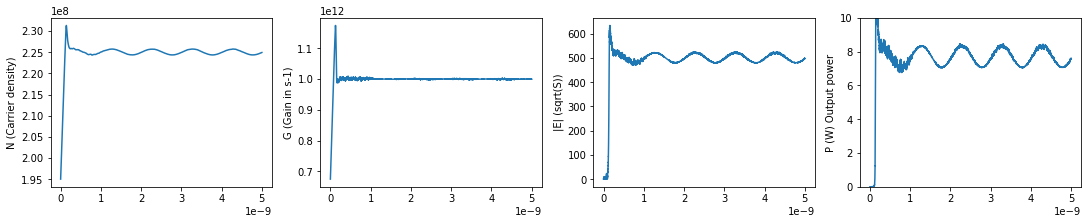

In [83]:
T = np.linspace(0, num_steps*h, num_steps)
fig, ax = plt.subplots(ncols = 4,constrained_layout=True)
fig.set_size_inches(15, 3)
P = (h_nu/tau_p)*np.abs(E)*np.abs(E)
ax[0].plot(T,N)
ax[1].plot(T,G)
ax[2].plot(T,np.abs(E))
ax[3].plot(T,P)
ax[3].set_ylim(0,10)
ax[0].set_ylabel('N (Carrier density)');
ax[1].set_ylabel('G (Gain in s-1)');
ax[2].set_ylabel('|E| (sqrt(S))');
ax[3].set_ylabel('P (W) Output power');

In [7]:
#Now let's sweep frequencies for 2e8 to 1e12 to see the small signal response
freq_sweep = [5e7,6e7,7e7,8e7,9e7,1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9,2e9,3e9,4e9,5e9,6e9,7e9,8e9,9e9,1e10,2e10,4e10,6e10,8e10,1e11,2e11,4e11,8e11,1e12]
S1 = np.zeros((3,len(freq_sweep)), dtype=float)
S0 = np.zeros((3,len(freq_sweep)), dtype=float)
I_factor = [1.2, 1.5, 2]

#Find S1 & S0 for different frequencies
num_steps   = 500000
h           = 1e-13 #ps
on_step     = 0
is_noise    = 1
s           = 5e-07
for j,factor in enumerate(I_factor):
  I_on        = factor*I_th
  for i,omega in enumerate(freq_sweep):
    w           = omega
    E, G, N, I  = evolve_small_signal(num_steps, h, s, is_noise, I_on, on_step, w)
    h_stable = int(on_step + (1e-09/h)) #on time + 1ns
    E_dummy = np.zeros(5000000) #zero padding
    E_stable = np.concatenate((E[h_stable:-1],E_dummy), axis=None)
    f = np.fft.fftshift(np.fft.fftfreq(len(E_stable), h))
    N = len(f)
    PSD = np.array(np.abs(np.fft.fftshift(np.fft.fft((E_stable)/N))) ** 2)
    #averaging power at w +- 2e8 frequencies
    idx = np.where(((f>(w - 1e7))&(f<(w + 1e7))))
    S1[j][i] = np.sum(PSD[idx])/len(idx)
    idx = np.where(((f>(0 - 1e7))&(f<(0 + 1e7))))
    S0[j][i] = np.sum(PSD[idx])/len(idx)  
  print(S1[j])
  print(S0[j])

[1.64225225e+02 6.83415110e+01 7.10134061e+01 3.01015844e+01
 6.91752540e+01 1.76341687e+02 4.51662478e+01 1.90681826e+02
 2.02224858e+01 1.21850475e+02 4.72501983e+01 6.62709041e+01
 6.60723897e+01 6.06617598e+01 5.94655659e+01 1.81106390e+01
 8.47511598e+01 8.58091255e+01 2.73462979e+01 2.78197237e+01
 2.23186046e+00 1.04528540e+00 2.86689851e+00 1.96160153e+00
 1.92855632e-01 7.04489466e-03 2.80401029e-04 5.30224429e-04
 2.26374106e-04 8.16631523e-06 4.11156148e-06 1.39814550e-06
 2.77048499e-07]
[ 425.50910929   42.36822299  588.81441623  503.59652093  314.31037678
  614.52960867   68.54807209  466.40448897   30.05309052  471.79835617
  157.37709925  125.06938119  228.52874734  158.73225444  277.86753678
   93.56741489  250.64814233  361.51492885  223.70193923  586.52276666
   96.1719978    63.89791721  368.21288258  362.97221411  748.79571019
  466.68620285  165.26742375  427.28190994  157.69018639  440.17046744
 1072.96994955  791.66828142 1227.37657409]
[2.19748865e+02 1.2753819

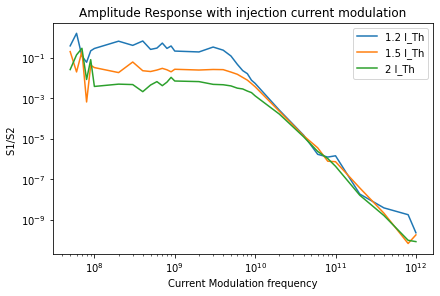

In [8]:
#finding AM
AM = S1
AM = np.divide(S1,S0)
fig, ax = plt.subplots(ncols = 1,constrained_layout=True)
ax.plot(freq_sweep, AM[0], label='1.2 I_Th')
ax.plot(freq_sweep, AM[1], label='1.5 I_Th')
ax.plot(freq_sweep, AM[2], label='2 I_Th')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('S1/S2 ');
ax.set_xlabel('Current Modulation frequency');
ax.set_title('Amplitude Response with injection current modulation')
ax.legend()

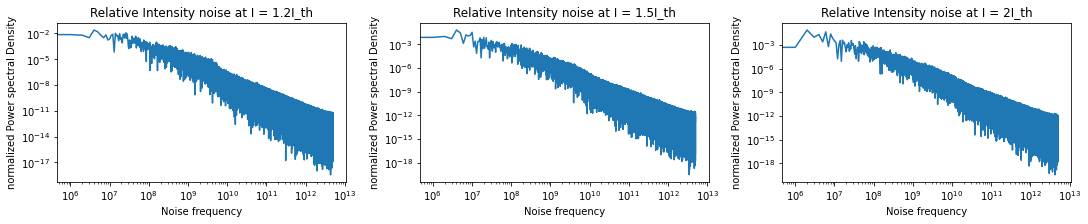

In [11]:
#Let's now try to find the  RIN spectrum at different current values using small signal model
freq_sweep  = [5e7,6e7,7e7,8e7,9e7,1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9,2e9,3e9,4e9,5e9,6e9,7e9,8e9,9e9,1e10,2e10,4e10,6e10,8e10,1e11,2e11,4e11,8e11,1e12]
#RIN         = np.zeros((3,len(freq_sweep)), dtype=float)
I_factor    = [1.2, 1.5, 2]
num_steps   = 10000000
h           = 1e-13 #ps
on_step     = 0
is_noise    = 1
s           = 5e-07
fig, ax     = plt.subplots(ncols = 3,constrained_layout=True)
fig.set_size_inches(15, 3)
for j,factor in enumerate(I_factor):
  I_on        = factor*I_th
  E, G, N, I  = evolve_system(num_steps, h, s, is_noise, I_on, on_step)
  h_stable    = int(on_step + (1e-09/h)) #on time + 1ns
  #for RIN, we will use the normalized Electric field as its a ratio between noise and average power
  E_dummy     = np.zeros(1) #zero padding
  E_normalized= E[h_stable:-1]/np.average(np.abs(E[h_stable:-1]))
  E_stable    = np.concatenate((E_normalized,E_dummy), axis=None)
  f           = np.fft.fftshift(np.fft.fftfreq(len(E_stable), h))
  N           = len(f)
  PSD         = np.array(np.abs(np.fft.fftshift(np.fft.fft((E_stable)/N))) ** 2)
  ax[j].plot(f[int(N/2):-1],PSD[int(N/2):-1])
  ax[j].set_xscale('log')
  ax[j].set_yscale('log')
  ax[j].set_ylabel('normalized Power spectral Density');
  ax[j].set_xlabel('Noise frequency');
  ax[j].set_title('Relative Intensity noise at I = ' +str(factor) + str('I_th'))
